# Author: Kerem Kazan
# Title: Chess Commentator Transformer - Tokenization

# Encoder Tokenizer

In [ ]:
# !pip install transformers==4.45.2
# !pip install chess

In [3]:
DATASET_ROOT = "./dataset/data"
DF_FILE = f"{DATASET_ROOT}/gameknot_annotated_positions_filtered.csv"
ENCODER_TOKENIZER_DIR = f"{DATASET_ROOT}/simple_encoder_tokenizer"
DECODER_TOKENIZER_DIR = f"{DATASET_ROOT}/simple_decoder_tokenizer"

In [4]:
# Let's first load our dataframe:

import pandas as pd

df = pd.read_csv(DF_FILE)

print(f"Loaded {len(df)} rows")

Loaded 275958 rows


In [5]:
# Let's pull our visualization function from the previous notebook:

import chess
import chess.svg
from IPython.display import display, HTML

def display_data_item(data_item):
  print(data_item["fen_before"])
  board_before = chess.Board(data_item['fen_before'])
  move = chess.Move.from_uci(data_item['uci'])
  # turn = "White" if data_item['is_white'] == "True" else "Black"
  turn="White"
  size=390

  svg = chess.svg.board(
    board_before,
    arrows=[chess.svg.Arrow(move.from_square, move.to_square)],
    size=size
  )

  # Create HTML to display boards side by side
  html = f"""
  <div>
    <table>
      <tr>
        <td>Move</td>
        <td>{data_item['uci']}</td>
      </tr>
      <tr>
        <td>Move #</td>
        <td>{data_item['full_move_number']}</td>
      </tr>
      <tr>
        <td>Turn</td>
        <td>{turn}</td>
      </tr>
      <tr>
        <td>Comment</td>
        <td>{data_item['comment']}</td>
      </tr>
    </table>
    <div style="display: flex; gap: 20px;">
      <svg width="{size}" height="{size}">{svg}</svg>
    </div>
  </div>
  """
  display(HTML(html))


In [6]:
display_data_item(df.iloc[0])

rnb1kbnr/ppp2ppp/8/3qp3/8/5N2/PPPP1PPP/RNBQKB1R w KQkq - 0 4


Move,b1c3
Move #,4
Turn,White
Comment,my basic opening.


We now have the difficult task of converting the board + move to a sequence of tokens. The FEN notation does not strike me as a particularly useful pattern for the encoder tokenizer. So in this first attempt, we will use the python-chess library to extract additional information from the board and move, and convert them to a sequence of tokens.

Pay attention to the usage of [CLS] and [SEP] tokens. These are placed to separate sub-sequences in preparation for the encoder model.

In [7]:
import chess

def _color_to_sequence_inner(color: chess.Color) -> str:
  return "WHITE" if color == chess.WHITE else "BLACK"

def _piece_to_sequence(piece) -> str:
  if piece is None:
    return " EMPTY "
  
  color = _color_to_sequence_inner(piece.color)
  
  return f"{color}_{chess.piece_name(piece.piece_type).upper()}"

def _piece_on_square_to_sequence(board: chess.Board, square: int) -> str:
    piece = board.piece_at(square)
    if not piece:
      return " EMPTY_SQUARE "
    
    return _piece_to_sequence(piece)

def _square_to_sequence(square: chess.Square) -> str:
  return f" SQUARE_{chess.SQUARE_NAMES[square].upper()}"

def _board_squares_to_sequence(board: chess.Board) -> str:
  piece_on_square_strs = []
  for i in range(64):
    piece = board.piece_at(i)
    if piece is not None:
      piece_str = _piece_on_square_to_sequence(board, i)
      square_str = _square_to_sequence(i)
      piece_on_square_str = f"{piece_str} ON {square_str}"
      piece_on_square_strs.append(piece_on_square_str)
  return " ".join(piece_on_square_strs)

def _castling_rights_to_sequence(board: chess.Board) -> str:
    # Castling rights
    castling_rights = []
    if board.has_kingside_castling_rights(chess.WHITE):
      castling_rights.append(f" WHITE_HAS_KINGSIDE_CASTLING_RIGHTS ")
    if board.has_queenside_castling_rights(chess.WHITE):
      castling_rights.append(f" WHITE_HAS_QUEENSIDE_CASTLING_RIGHTS ")
    if board.has_kingside_castling_rights(chess.BLACK):
      castling_rights.append(f" BLACK_HAS_KINGSIDE_CASTLING_RIGHTS ")
    if board.has_queenside_castling_rights(chess.BLACK):
      castling_rights.append(f" BLACK_HAS_QUEENSIDE_CASTLING_RIGHTS ")

    return " ".join(castling_rights)

def _game_state_sequence(board: chess.Board) ->str:
  game_state = []
  if board.is_checkmate():
    game_state.append(f" IS_CHECKMATE ")
  elif board.is_check():
    game_state.append(f" IS_CHECK ")

  if board.is_insufficient_material():
    game_state.append(f" IS_INSUFFICIENT_MATERIAL ")
  if board.is_stalemate():
    game_state.append(f" IS_STALEMATE ")
  
  return " ".join(game_state)

def _board_to_sequence(board: chess.Board) -> str:
  sections = [
    _board_squares_to_sequence(board),
    _castling_rights_to_sequence(board),
    _game_state_sequence(board)
  ]

  return " ".join(s for s in sections if s.strip())

def _move_state_sequence(board: chess.Board, move: chess.Move) -> str:

  moving_piece = board.piece_at(move.from_square)

  moving_piece_str = _piece_to_sequence(moving_piece)

  sections = [
    moving_piece_str,
    " ON ",
    _square_to_sequence(move.from_square),
    " MOVES_TO ",
    _square_to_sequence(move.to_square),
  ]

  board_after = board.copy()
  board_after.push(move)

  
  if board.is_castling(move):
    sections.append(" [SEP] ")
    sections.append(f" CASTLES ")

  if board.is_capture(move):
    sections.append(" [SEP] ")
    sections.append(moving_piece_str)
    sections.append(f" CAPTURES ")
    sections.append(_piece_to_sequence(board.piece_at(move.to_square)))
    sections.append(" ON ")
    sections.append(_square_to_sequence(move.to_square))

  if board.gives_check(move):
    sections.append(" [SEP] ")
    sections.append(moving_piece_str)
    sections.append(f" GIVES_CHECK ")

  if move.promotion is not None:
    sections.append(" [SEP] ")
    sections.append(f" PROMOTES_TO ")
    new_piece = board_after.piece_at(move.to_square)
    new_piece_str = _piece_to_sequence(new_piece)
    sections.append(new_piece_str)

  attacked_squares = []
  defended_squares = []
  controlled_squares = []

  for attack in board_after.attacks(move.to_square):
    target_piece = board_after.piece_at(attack)
    controlled_square = _square_to_sequence(attack)

    controlled_squares.append(controlled_square)

    if target_piece is not None:
      controlled_piece = f"{_piece_on_square_to_sequence(board_after, attack)} ON {controlled_square}"
      if moving_piece.color == target_piece.color:
        defended_squares.append(controlled_piece)
      else:
        attacked_squares.append(controlled_piece)

  if attacked_squares:
    sections.append(" [SEP] ")
    sections.append(moving_piece_str)
    sections.append(" ATTACKS ")
    sections.extend(attacked_squares)
  
  if defended_squares:
    sections.append(" [SEP] ")
    sections.append(moving_piece_str)
    sections.append(" DEFENDS ")
    sections.extend(defended_squares)

  if controlled_square:
    sections.append(" [SEP] ")
    sections.append(moving_piece_str)
    sections.append(" CONTROLS ")
    sections.extend(controlled_squares)

  return " ".join(sections)

def to_sequence(board: chess.Board, move: chess.Move) -> str:

  board_after = board.copy()
  board_after.push(move)

  seq = [
    _move_state_sequence(board, move),
    _board_to_sequence(board),
    _game_state_sequence(board_after),
  ]

  joined = " [SEP] ".join(seq)
  tokens = joined.split(" ")

  result_tokens = []

  for token in tokens:
    if token.strip():
      result_tokens.append(token)

  if result_tokens[-1] != "[SEP]":
    result_tokens.append("[SEP]")

  cleaned = " ".join(result_tokens)
  return f"[CLS] {cleaned}"

d = df.sample(1).iloc[0]

board = chess.Board(d["fen_before"])
move = chess.Move.from_uci(d["uci"])
seq = to_sequence(board, move)

seq_items = seq.split(" ")

print("# Tokens:", len(seq_items))
print(seq)
display_data_item(d)

# Tokens: 127
[CLS] WHITE_BISHOP ON SQUARE_E5 MOVES_TO SQUARE_G3 [SEP] WHITE_BISHOP ATTACKS BLACK_PAWN ON SQUARE_C7 [SEP] WHITE_BISHOP DEFENDS WHITE_PAWN ON SQUARE_F2 WHITE_PAWN ON SQUARE_H2 [SEP] WHITE_BISHOP CONTROLS SQUARE_F2 SQUARE_H2 SQUARE_F4 SQUARE_H4 SQUARE_E5 SQUARE_D6 SQUARE_C7 [SEP] WHITE_ROOK ON SQUARE_A1 WHITE_QUEEN ON SQUARE_D1 WHITE_KING ON SQUARE_E1 WHITE_BISHOP ON SQUARE_F1 WHITE_ROOK ON SQUARE_H1 WHITE_PAWN ON SQUARE_B2 WHITE_PAWN ON SQUARE_E2 WHITE_PAWN ON SQUARE_F2 WHITE_PAWN ON SQUARE_G2 WHITE_PAWN ON SQUARE_H2 WHITE_PAWN ON SQUARE_A3 WHITE_KNIGHT ON SQUARE_C3 WHITE_KNIGHT ON SQUARE_F3 WHITE_PAWN ON SQUARE_D4 BLACK_PAWN ON SQUARE_D5 WHITE_BISHOP ON SQUARE_E5 BLACK_KNIGHT ON SQUARE_H5 BLACK_KNIGHT ON SQUARE_C6 BLACK_PAWN ON SQUARE_F6 BLACK_PAWN ON SQUARE_A7 BLACK_PAWN ON SQUARE_B7 BLACK_PAWN ON SQUARE_C7 BLACK_BISHOP ON SQUARE_E7 BLACK_PAWN ON SQUARE_G7 BLACK_PAWN ON SQUARE_H7 BLACK_ROOK ON SQUARE_A8 BLACK_BISHOP ON SQUARE_C8 BLACK_QUEEN ON SQUARE_D8 BLACK_KING ON S

Move,e5g3
Move #,9
Turn,White
Comment,He retreats...


In [8]:
# Before we train our encoder tokenizer, let's create a corpus:

df["input_sequence"] = df.apply(lambda row: to_sequence(chess.Board(row["fen_before"]), chess.Move.from_uci(row["uci"])), axis=1)

print(df["input_sequence"].iloc[0])

[CLS] WHITE_KNIGHT ON SQUARE_B1 MOVES_TO SQUARE_C3 [SEP] WHITE_KNIGHT ATTACKS BLACK_QUEEN ON SQUARE_D5 [SEP] WHITE_KNIGHT DEFENDS WHITE_QUEEN ON SQUARE_D1 WHITE_PAWN ON SQUARE_A2 [SEP] WHITE_KNIGHT CONTROLS SQUARE_B1 SQUARE_D1 SQUARE_A2 SQUARE_E2 SQUARE_A4 SQUARE_E4 SQUARE_B5 SQUARE_D5 [SEP] WHITE_ROOK ON SQUARE_A1 WHITE_KNIGHT ON SQUARE_B1 WHITE_BISHOP ON SQUARE_C1 WHITE_QUEEN ON SQUARE_D1 WHITE_KING ON SQUARE_E1 WHITE_BISHOP ON SQUARE_F1 WHITE_ROOK ON SQUARE_H1 WHITE_PAWN ON SQUARE_A2 WHITE_PAWN ON SQUARE_B2 WHITE_PAWN ON SQUARE_C2 WHITE_PAWN ON SQUARE_D2 WHITE_PAWN ON SQUARE_F2 WHITE_PAWN ON SQUARE_G2 WHITE_PAWN ON SQUARE_H2 WHITE_KNIGHT ON SQUARE_F3 BLACK_QUEEN ON SQUARE_D5 BLACK_PAWN ON SQUARE_E5 BLACK_PAWN ON SQUARE_A7 BLACK_PAWN ON SQUARE_B7 BLACK_PAWN ON SQUARE_C7 BLACK_PAWN ON SQUARE_F7 BLACK_PAWN ON SQUARE_G7 BLACK_PAWN ON SQUARE_H7 BLACK_ROOK ON SQUARE_A8 BLACK_KNIGHT ON SQUARE_B8 BLACK_BISHOP ON SQUARE_C8 BLACK_KING ON SQUARE_E8 BLACK_BISHOP ON SQUARE_F8 BLACK_KNIGHT ON SQU

In [9]:
tokens_set = set()

for row in df["input_sequence"]:
  cur_tokens = row.split(" ")
  for cur_token in cur_tokens:
    cur_token = cur_token.strip()
    if len(cur_token):
      tokens_set.add(cur_token)

print(f"Set size: {len(tokens_set)}")


Set size: 96


In [11]:
# Perfect. Our input space is extremely compact: Just 96 tokens are enough to encode all possible board + move sequences. Let's train our encoder tokenizer:

In [12]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from transformers import PreTrainedTokenizerFast

def tokenizer_from_vocab(vocab_set):
    vocab_list = sorted(vocab_set)  # turn set into list
    vocab_list.remove("[CLS]")
    vocab_list.remove("[SEP]")
    tokenizer_model = models.WordLevel(unk_token="[UNK]")

    tokenizer = Tokenizer(tokenizer_model)
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

    # Train the tokenizer using the provided vocab list
    trainer = trainers.WordLevelTrainer(
        special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"],
    )
    # print(vocab_list)

    tokenizer.train_from_iterator(vocab_list, trainer)

    # Wrap with HF interface
    hf_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer,
        unk_token="[UNK]",
        pad_token="[PAD]",
        cls_token="[CLS]",
        sep_token="[SEP]",
        mask_token="[MASK]"
    )

    return hf_tokenizer


encoder_tokenizer = tokenizer_from_vocab(tokens_set)

print(encoder_tokenizer.vocab_size)
print(len(encoder_tokenizer.vocab))
print(encoder_tokenizer.vocab)

99
99
{'SQUARE_B8': 42, 'SQUARE_H6': 88, 'SQUARE_C7': 49, 'SQUARE_E1': 59, 'SQUARE_A8': 34, 'SQUARE_H8': 90, 'SQUARE_B6': 40, 'SQUARE_F4': 70, 'WHITE_QUEEN': 97, 'SQUARE_D8': 58, 'IS_CHECKMATE': 21, 'CAPTURES': 14, 'SQUARE_F2': 68, 'SQUARE_F1': 67, 'EMPTY': 18, 'SQUARE_G7': 81, 'SQUARE_D7': 57, 'SQUARE_H5': 87, 'SQUARE_D3': 53, 'CASTLES': 15, 'SQUARE_B2': 36, 'SQUARE_E4': 62, 'BLACK_PAWN': 11, 'IS_STALEMATE': 23, 'DEFENDS': 17, 'SQUARE_C5': 47, 'GIVES_CHECK': 19, 'SQUARE_C8': 50, 'SQUARE_D5': 55, 'SQUARE_E5': 63, 'SQUARE_H1': 83, '[UNK]': 0, 'SQUARE_B3': 37, 'SQUARE_C3': 45, 'SQUARE_D6': 56, 'SQUARE_A3': 29, 'SQUARE_B4': 38, 'SQUARE_E6': 64, 'SQUARE_G4': 78, 'ON': 25, 'SQUARE_G5': 79, 'MOVES_TO': 24, 'ATTACKS': 5, 'BLACK_KNIGHT': 10, 'IS_INSUFFICIENT_MATERIAL': 22, 'SQUARE_B5': 39, 'PROMOTES_TO': 26, 'WHITE_KING': 94, 'BLACK_QUEEN': 12, 'SQUARE_A5': 31, 'SQUARE_F7': 73, 'SQUARE_G1': 75, '[PAD]': 1, 'WHITE_BISHOP': 91, 'SQUARE_G3': 77, 'SQUARE_E3': 61, 'SQUARE_F6': 72, 'SQUARE_F5': 71, 

In [13]:
input_sequence = df.iloc[0]["input_sequence"]
encoded = encoder_tokenizer.encode(input_sequence)

print("Encoded sequence:")
print(encoded)

print("Input sequence:")
print(input_sequence)

print("Decoded sequence:")
decoded = encoder_tokenizer.decode(encoded)
print(decoded)

Encoded sequence:
[2, 95, 25, 35, 24, 45, 3, 95, 5, 12, 25, 55, 3, 95, 17, 97, 25, 51, 96, 25, 28, 3, 95, 16, 35, 51, 28, 60, 30, 62, 39, 55, 3, 98, 25, 27, 95, 25, 35, 91, 25, 43, 97, 25, 51, 94, 25, 59, 91, 25, 67, 98, 25, 83, 96, 25, 28, 96, 25, 36, 96, 25, 44, 96, 25, 52, 96, 25, 68, 96, 25, 76, 96, 25, 84, 95, 25, 69, 12, 25, 55, 11, 25, 63, 11, 25, 33, 11, 25, 41, 11, 25, 49, 11, 25, 73, 11, 25, 81, 11, 25, 89, 13, 25, 34, 10, 25, 42, 6, 25, 50, 9, 25, 66, 6, 25, 74, 10, 25, 82, 13, 25, 90, 92, 93, 7, 8, 3]
Input sequence:
[CLS] WHITE_KNIGHT ON SQUARE_B1 MOVES_TO SQUARE_C3 [SEP] WHITE_KNIGHT ATTACKS BLACK_QUEEN ON SQUARE_D5 [SEP] WHITE_KNIGHT DEFENDS WHITE_QUEEN ON SQUARE_D1 WHITE_PAWN ON SQUARE_A2 [SEP] WHITE_KNIGHT CONTROLS SQUARE_B1 SQUARE_D1 SQUARE_A2 SQUARE_E2 SQUARE_A4 SQUARE_E4 SQUARE_B5 SQUARE_D5 [SEP] WHITE_ROOK ON SQUARE_A1 WHITE_KNIGHT ON SQUARE_B1 WHITE_BISHOP ON SQUARE_C1 WHITE_QUEEN ON SQUARE_D1 WHITE_KING ON SQUARE_E1 WHITE_BISHOP ON SQUARE_F1 WHITE_ROOK ON SQUARE_

In [32]:
print(f"Length: {len(encoder_tokenizer.encode('BLACK_QUEEN'))}") # Should be just 1 token
encoder_tokenizer.save_pretrained(ENCODER_TOKENIZER_DIR)

Length: 1


('./dataset/tokenizers/simple_encoder_tokenizer/tokenizer_config.json',
 './dataset/tokenizers/simple_encoder_tokenizer/special_tokens_map.json',
 './dataset/tokenizers/simple_encoder_tokenizer/tokenizer.json')

In [17]:
# Our encoder tokenizer is ready. Let's see how long the sequences are:

In [18]:
import numpy as np

encoder_sequence_lengths = [len(encoder_tokenizer.encode(row['input_sequence'], add_special_tokens=True)) for _, row in df.iterrows()]


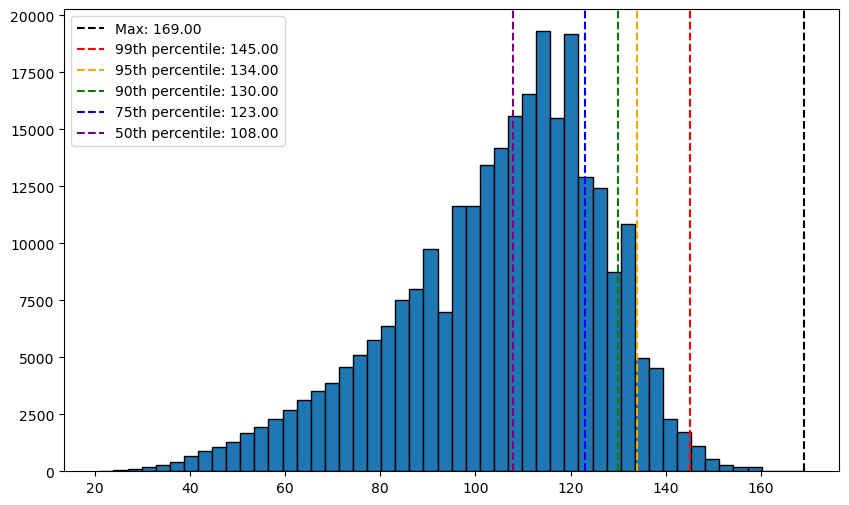

In [19]:
import matplotlib.pyplot as plt

def plot_sequence_lengths(sequence_lengths):
  p99 = np.percentile(sequence_lengths, 99)
  p95 = np.percentile(sequence_lengths, 95)
  p90 = np.percentile(sequence_lengths, 90)
  p75 = np.percentile(sequence_lengths, 80)
  p50 = np.percentile(sequence_lengths, 50)
  max_len = max(sequence_lengths)

  # Plot the distribution
  plt.figure(figsize=(10, 6))
  plt.hist(sequence_lengths, bins=50, edgecolor='black')
  plt.axvline(max_len, color='black', linestyle='--', label=f'Max: {max_len:.2f}')
  plt.axvline(p99, color='red', linestyle='--', label=f'99th percentile: {p99:.2f}')
  plt.axvline(p95, color='orange', linestyle='--', label=f'95th percentile: {p95:.2f}')
  plt.axvline(p90, color='green', linestyle='--', label=f'90th percentile: {p90:.2f}')
  plt.axvline(p75, color='blue', linestyle='--', label=f'75th percentile: {p75:.2f}')
  plt.axvline(p50, color='purple', linestyle='--', label=f'50th percentile: {p50:.2f}')
  plt.legend()
  plt.show()

plot_sequence_lengths(encoder_sequence_lengths)

In [17]:
# Nice bell curve. Let's move on to the decoder tokenizer.

Removing outliers
Before: 275958
After: 273593


# Decoder Tokenizer

In [20]:
# Let's train a compact BPE tokenizer for the decoder:

In [ ]:
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers, normalizers
from transformers import PreTrainedTokenizerFast
import pandas as pd

# Load your comment corpus
comments = df["comment"].dropna().astype(str).str.lower().tolist()

def train_decoder_tokenizer(corpus, vocab_size):
    tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

    # Normalization: lowercase and remove accents
    tokenizer.normalizer = normalizers.Sequence([
        normalizers.Lowercase(), # Convert to lowercase
        normalizers.StripAccents() # Remove accents
    ])

    # Pre-tokenization: split on whitespace and punctuation
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)

    # Decoder for pretty output
    tokenizer.decoder = decoders.ByteLevel()

    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        special_tokens=["[UNK]", "[PAD]", "[BOS]", "[EOS]",]
    )

    tokenizer.train_from_iterator(corpus, trainer)

    hf_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer,
        unk_token="[UNK]",
        pad_token="[PAD]",
        bos_token="[BOS]",
        eos_token="[EOS]"
    )

    return hf_tokenizer

decoder_tokenizer = train_decoder_tokenizer(comments, 1000)


('../dataset/data/simple_decoder_tokenizer/tokenizer_config.json',
 '../dataset/data/simple_decoder_tokenizer/special_tokens_map.json',
 '../dataset/data/simple_decoder_tokenizer/tokenizer.json')

In [33]:
# Let's save the decoder tokenizer:
decoder_tokenizer.save_pretrained(DECODER_TOKENIZER_DIR)

('./dataset/tokenizers/simple_decoder_tokenizer/tokenizer_config.json',
 './dataset/tokenizers/simple_decoder_tokenizer/special_tokens_map.json',
 './dataset/tokenizers/simple_decoder_tokenizer/tokenizer.json')

In [34]:
for i in range(10):

  input_comment = df.iloc[i]["comment"]
  encoded_comment = decoder_tokenizer.encode(input_comment)

  print("Encoded comment:")
  print(encoded_comment)

  print("Input comment:")
  print(input_comment)

  decoded_comment = decoder_tokenizer.decode(
    encoded_comment,
    skip_special_tokens=True
  )

  print("Decoded comment:")
  print(decoded_comment)
  print("______")


Encoded comment:
[139, 75, 111, 249, 478, 16]
Input comment:
my basic opening.
Decoded comment:
 my basic opening.
______
Encoded comment:
[149, 87, 54, 218, 134, 139, 609, 16, 156, 188, 76, 469, 505, 72, 201, 16]
Input comment:
revenge for my mistake. But now I am down a rook.
Decoded comment:
 revenge for my mistake. but now i am down a rook.
______
Encoded comment:
[72, 133, 134, 72, 177, 82, 51, 16]
Input comment:
a pawn for a knight OK.
Decoded comment:
 a pawn for a knight ok.
______
Encoded comment:
[188, 142, 966, 527, 86, 118, 523, 16]
Input comment:
Now it turns serious.
Decoded comment:
 now it turns serious.
______
Encoded comment:
[152, 137, 347, 76, 469, 599, 89, 88, 132, 505, 304, 125, 181, 79, 922, 349, 16]
Input comment:
At this time I am trying to cut down some of his power pieces.
Decoded comment:
 at this time i am trying to cut down some of his power pieces.
______
Encoded comment:
[347, 134, 72, 531, 16, 76, 361, 190, 139, 476, 62, 105, 524, 349, 806, 16]
Input co

In [35]:
import numpy as np

decoder_token_lengths = [len(decoder_tokenizer.encode(row['comment'], add_special_tokens=True)) for _, row in df.iterrows()]

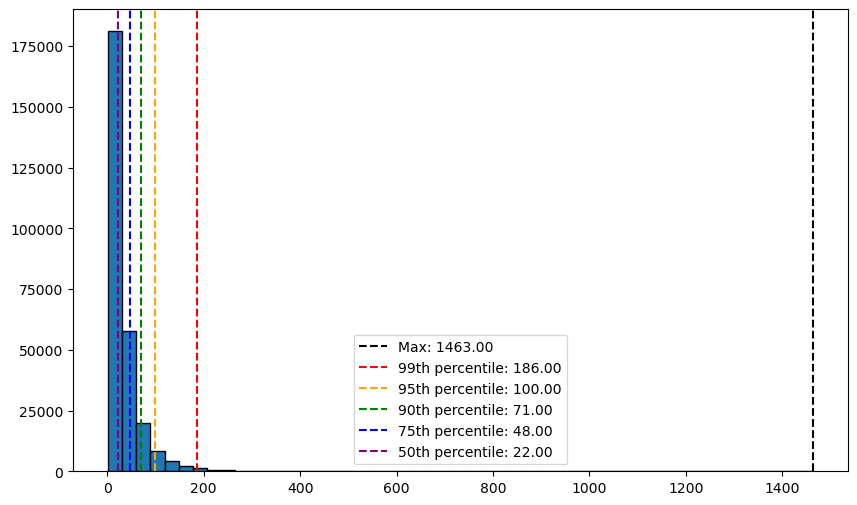

In [24]:
plot_sequence_lengths(decoder_token_lengths)

In [25]:
# Extremely right skewed. Let's remove the top 1% of longest decoder sequences:

print("Removing outliers")
print(f"Before: {len(df)}")
cutoff = np.percentile(decoder_token_lengths, 99)
df = df[decoder_token_lengths <= cutoff].reset_index(drop=True)
print(f"After: {len(df)}")


Removing outliers
Before: 275958
After: 273207


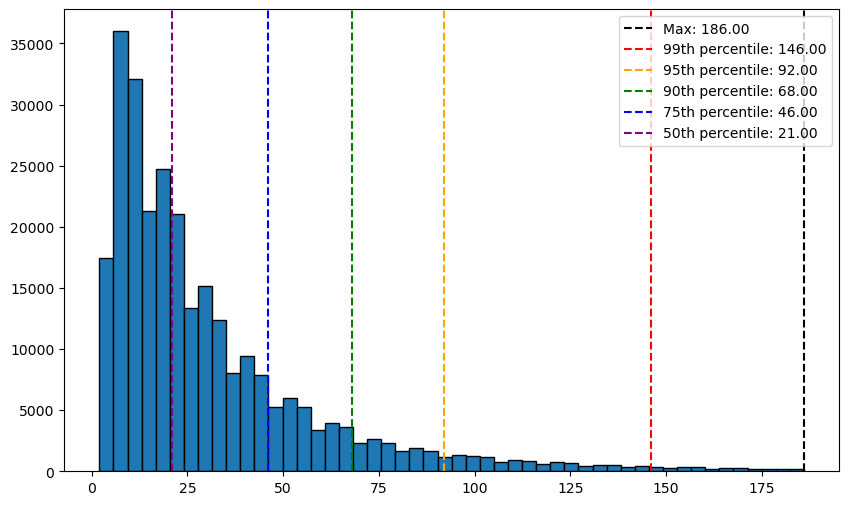

In [26]:
decoder_token_lengths_after_cutoff = [len(decoder_tokenizer.encode(row['comment'], add_special_tokens=True)) for _, row in df.iterrows()]

plot_sequence_lengths(decoder_token_lengths_after_cutoff)

In [27]:
# Still, a bit right skewed. Let's remove the top 1% of longest decoder sequences again:

print("Removing outliers")
print(f"Before: {len(df)}")
cutoff = np.percentile(decoder_token_lengths_after_cutoff, 99)
df = df[decoder_token_lengths_after_cutoff <= cutoff].reset_index(drop=True)
print(f"After: {len(df)}")


Removing outliers
Before: 273207
After: 270525


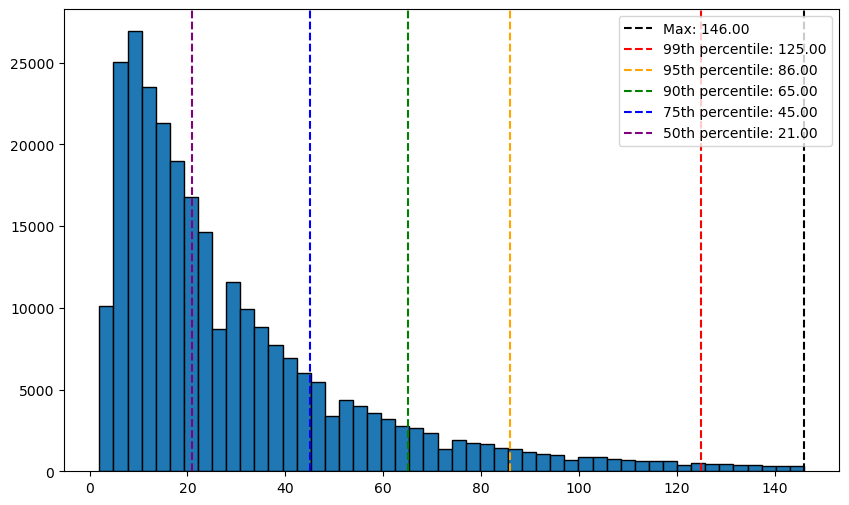

In [28]:
decoder_token_lengths_after_final_cutoff = [len(decoder_tokenizer.encode(row['comment'], add_special_tokens=True)) for _, row in df.iterrows()]

plot_sequence_lengths(decoder_token_lengths_after_final_cutoff)

In [30]:
# Looks good. Let's save the data frames for later use:

SIMPLE_ENCODER_DATA_FILE = f"{DATASET_ROOT}/simple_encoder_dataset.csv"
df.to_csv(SIMPLE_ENCODER_DATA_FILE, index=False)